# Desafio Técnico – Hackathon Forecast Big Data 2025

# Análise de dados

In [14]:
# Importando as bibliotecas necessárias
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col
from pyspark.sql import Window
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import subprocess


import warnings
warnings.filterwarnings("ignore")

## Iniciando a Sessão Spark

In [2]:
spark = SparkSession.builder \
    .appName("Desafio Técnico - Hackathon Forescast Big Data 2025") \
    .getOrCreate()

## Lendo os dataframes

In [3]:
# Declarando o caminho do arquivo 1
arquivo_1 = '/content/part-00000-tid-2779033056155408584-f6316110-4c9a-4061-ae48-69b77c7c8c36-4-1-c000.snappy.parquet'

# Lendo o arquivo 1
df_arquivo_1 = spark.read.parquet(arquivo_1)

In [ ]:
# Visualizando 5 linhas do arquivo 1
df_arquivo_1.show(5)

Comentário: O arquivo 1 é base de dados dos endereços dos pontos de vendas.

In [4]:
# Declarando o caminho do arquivo 2
arquivo_2 = '/content/part-00000-tid-5196563791502273604-c90d3a24-52f2-4955-b4ec-fb143aae74d8-4-1-c000.snappy.parquet'

# Lendo o arquivo 2
df_arquivo_2 = spark.read.parquet(arquivo_2)

In [ ]:
# Visualizando o cabeçalho do arquivo 2
df_arquivo_2.show(5)

Comentário: O arquivo 2 é a base de dados do histórico de transações nos pontos de vendas

In [5]:
# Declarando o caminho do arquivo 3
arquivo_3 = '/content/part-00000-tid-6364321654468257203-dc13a5d6-36ae-48c6-a018-37d8cfe34cf6-263-1-c000.snappy.parquet'

# Lendo o arquivo 3
df_arquivo_3 = spark.read.parquet(arquivo_3)

In [ ]:
# Visualizando o cabeçalho do arquivo 3
df_arquivo_3.show(5)

Comentário: O arquivo 3 é base de dados de catálogos de produtos.

## Análise, limpeza e tratamento dos dados

In [30]:
# Visualizando o Schema do df_arquivo 1
df_arquivo_1.printSchema()

root
 |-- pdv: long (nullable = true)
 |-- premise: string (nullable = true)
 |-- categoria_pdv: string (nullable = true)
 |-- zipcode: integer (nullable = true)



In [10]:
# Quantidade de limhas
df_arquivo_1.count()

14419

Possui 14.419 pontos de venda

In [11]:
# Verificando se há valores nulos no df_arquivo_1
df_arquivo_1.select([F.sum(col(c).isNull().cast("int")).alias(c) for c in df_arquivo_1.columns]).show()

+---+-------+-------------+-------+
|pdv|premise|categoria_pdv|zipcode|
+---+-------+-------------+-------+
|  0|      0|            0|      0|
+---+-------+-------------+-------+



Não há valores nulos ou ausentes nas colunas.

In [31]:
# Visualizando o Schema do df_arquivo 2
df_arquivo_2.printSchema()

root
 |-- internal_store_id: string (nullable = true)
 |-- internal_product_id: string (nullable = true)
 |-- distributor_id: string (nullable = true)
 |-- transaction_date: date (nullable = true)
 |-- reference_date: date (nullable = true)
 |-- quantity: double (nullable = true)
 |-- gross_value: double (nullable = true)
 |-- net_value: double (nullable = true)
 |-- gross_profit: double (nullable = true)
 |-- discount: double (nullable = true)
 |-- taxes: double (nullable = true)



In [13]:
# Quantidade de limhas
df_arquivo_2.count()

6560698

A base de dados possui 6.560.698 transações de vendas no período de 2022.

In [14]:
# Verificando se há valores nulos no df_arquivo_2
df_arquivo_2.select([F.sum(col(c).isNull().cast("int")).alias(c) for c in df_arquivo_2.columns]).show()

+-----------------+-------------------+--------------+----------------+--------------+--------+-----------+---------+------------+--------+-----+
|internal_store_id|internal_product_id|distributor_id|transaction_date|reference_date|quantity|gross_value|net_value|gross_profit|discount|taxes|
+-----------------+-------------------+--------------+----------------+--------------+--------+-----------+---------+------------+--------+-----+
|                0|                  0|             0|               0|             0|       0|          0|        0|           0|       0|    0|
+-----------------+-------------------+--------------+----------------+--------------+--------+-----------+---------+------------+--------+-----+



Não há valores nulos ou ausentes nas colunas.

In [15]:
# Visualizando o Schema do df_arquivo 3
df_arquivo_3.printSchema()

root
 |-- produto: string (nullable = true)
 |-- categoria: string (nullable = true)
 |-- descricao: string (nullable = true)
 |-- tipos: string (nullable = true)
 |-- label: string (nullable = true)
 |-- subcategoria: string (nullable = true)
 |-- marca: string (nullable = true)
 |-- fabricante: string (nullable = true)



In [16]:
# Quantidade de linhas
df_arquivo_3.count()

192356316

Possui em torno de 192.356.316 produtos cadastrados na base de dados.

In [17]:
# Verificando se há valores nulos no df_arquivo_3
df_arquivo_3.select([F.sum(col(c).isNull().cast("int")).alias(c) for c in df_arquivo_3.columns]).show()

+-------+---------+---------+-----+--------+------------+-----+----------+
|produto|categoria|descricao|tipos|   label|subcategoria|marca|fabricante|
+-------+---------+---------+-----+--------+------------+-----+----------+
|      0|        0|        0|    0|39952179|           0|    0|         0|
+-------+---------+---------+-----+--------+------------+-----+----------+



A coluna rótulo apresenta dados nulos.

In [18]:
# Visualizando algumas linhas que contém nulos na coluna label
df_arquivo_3.filter(col("label").isNull()).show()

+-------------------+-----------------+--------------------+--------------------+-----+---------------+--------------------+--------------------+
|            produto|        categoria|           descricao|               tipos|label|   subcategoria|               marca|          fabricante|
+-------------------+-----------------+--------------------+--------------------+-----+---------------+--------------------+--------------------+
|6217366559810422145|Distilled Spirits|CENZON REPOSADO 1...|   Distilled Spirits| NULL|          Lager|Cenzon Reposado 1...|     Sazerac Spirits|
|6730874462632832069|            Draft|BRECKENRIDGE ROTT...|               Draft| NULL|          Lager|Breckenridge Rott...|       Tilray Brands|
|1891379416584527637|Distilled Spirits|SKOL LONDON DRY G...|   Distilled Spirits| NULL|Lager / Pilsner| Skol London Dry Gin|     Sazerac Spirits|
| 648296504146774233|Distilled Spirits|GOLD RUSH WHSKEY ...|   Distilled Spirits| NULL|  Other Package|           Gold Rush|

Conforme visto, a coluna label aparenta ser não se aplicar para determinado grupo de produtos.

## Análise exploratória dos dados

In [6]:
# Agrupando por PDV, produto e Semana
df_arquivo2_agrupado = (
    df_arquivo_2
    .withColumn("Semanal", F.date_trunc("week", F.col("transaction_date")))
    .groupBy("internal_store_id", "internal_product_id", "Semanal",'distributor_id')
    .agg(
        F.sum("quantity").alias("qtd_total"),
        F.sum("gross_value").alias("valor_total"),
        F.sum("net_value").alias("liquido_total"),
        F.sum("gross_profit").alias("lucro_bruto"),
        F.sum("discount").alias("desconto"),
        F.sum("taxes").alias("impostos")
    )
)

In [20]:
# Visualizando o dataframe
df_arquivo2_agrupado.show(5)

+-------------------+-------------------+-------------------+--------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  internal_store_id|internal_product_id|            Semanal|distributor_id|         qtd_total|       valor_total|     liquido_total|       lucro_bruto|          desconto|          impostos|
+-------------------+-------------------+-------------------+--------------+------------------+------------------+------------------+------------------+------------------+------------------+
|4603935898916442258|3371701102715312626|2022-05-30 00:00:00|             4|               1.0|            18.625|            18.625|             4.125|              3.75|               0.0|
|6116590439400664478|1835194265081182189|2022-11-14 00:00:00|             4|               3.0| 64.03500366210938| 55.48590850830078|12.774908065795898|             11.25| 8.549094200134277|
|4525686140465431990|6768257239218387792|2022

In [21]:
# Verificando o tamanho
df_arquivo2_agrupado.count()

6249014

In [22]:
# Aplicando a estatística descritiva no df_agrupado
descritiva = df_arquivo2_agrupado.describe()

# Arredonda os valores para facilitar a leitura
descritiva = descritiva.select(
    [col("summary")] + [F.round(col(c).cast("double"), 2).alias(c) for c in descritiva.columns if c != "summary"]
)

# Visualizando o resultado
descritiva.show()

+-------+--------------------+--------------------+--------------+---------+-----------+-------------+-----------+---------+---------+
|summary|   internal_store_id| internal_product_id|distributor_id|qtd_total|valor_total|liquido_total|lucro_bruto| desconto| impostos|
+-------+--------------------+--------------------+--------------+---------+-----------+-------------+-----------+---------+---------+
|  count|           6249014.0|           6249014.0|     6249014.0|6249014.0|  6249014.0|    6249014.0|  6249014.0|6249014.0|6249014.0|
|   mean|4.618938213316762...|4.381255150265282E18|          5.52|     8.53|     128.87|       125.06|      23.02|    29.05|     3.81|
| stddev|2.695740238749596...|2.755660140409642E18|          1.87|    82.48|     888.47|       887.13|      234.4|   394.32|    11.87|
|    min|1.000237487041964...|1.000423277513436...|          10.0|  -1530.0|   -42672.9|     -39848.0|  -274396.0| -13096.8| -4099.41|
|    max|9.979078001118497...|9.992850782918035...|    

A partir da análise estatísitca descritiva, percebe-se:
- quantity (quantidade): apresenta valor mínimo negativo, o que inicialmente não é consistente com a natureza da variável. É necessário investigar a origem desses registros, pois quantidades negativas podem indicar devoluções de produtos, avarias ou perdas.

- gross_value (faturamento): identificou-se valor mínimo negativo, o que demanda verificação adicional. Valores negativos podem ocorrer em devoluções, representando a reversão da receita bruta da venda original; como também podem significar avarias e ou perdas.

- net_value (faturamento líquido): aplica-se o mesmo raciocínio, sendo imprescindível analisar valores negativos. Tais registros podem refletir o estorno do faturamento líquido devido a devoluções, descontos ou ajustes fiscais.

- gross_profit (lucro bruto): a presença de valores negativos deve ser investigada. Em muitos casos, esses valores refletem o impacto da devolução sobre a margem financeira, revertendo o lucro obtido na venda original; também podem significar avarias e ou perdas.

- discount (desconto): embora descontos possam variar, valores negativos devem ser avaliados. Em devoluções, o sistema pode registrar o estorno do desconto aplicado na venda original, gerando valores negativos nesta coluna.

- taxes (taxas): a presença de valores negativos deve ser analisada, pois pode indicar estorno de impostos ou ajustes fiscais relacionados a devoluções, compensações ou correções contábeis.

In [23]:
# Por produto
df_arquivo2_agrupado.groupBy("internal_product_id").agg(
    F.mean("qtd_total").alias("media"),
    F.stddev("qtd_total").alias("desvio"),
    F.min("qtd_total").alias("min"),
    F.max("qtd_total").alias("max")
).show(10)

+-------------------+------------------+------------------+--------------------+------------------+
|internal_product_id|             media|            desvio|                 min|               max|
+-------------------+------------------+------------------+--------------------+------------------+
|1837429607327399565| 1.087618403247632|0.6477386224560762|                -2.0|               7.0|
|6418740321929174358|12.344444444444445| 10.08855298708806|                 0.0|              72.0|
|1802809521974227093|  136.244239327545| 420.9374681728218|-2.38418579101562...|3586.9999925494194|
|6972914798143297886|1.7261058447520596|2.7780445859987966|               -10.0|              50.0|
|6169936842448474270|             5.125|2.1664598743334187|                 0.0|               7.0|
|7066790008526768288|6.2317073170731705|4.6489047707605415|                -6.0|              36.0|
|3626084398019816474|46.657701805051786| 91.82154570900411|               -12.0| 1336.999997973442|


In [24]:
# Por PDV
df_arquivo2_agrupado.groupBy("internal_store_id").agg(
    F.mean("qtd_total").alias("media"),
    F.stddev("qtd_total").alias("desvio"),
    F.min("qtd_total").alias("min"),
    F.max("qtd_total").alias("max")
).show(10)

+-------------------+------------------+------------------+------------------+------------------+
|  internal_store_id|             media|            desvio|               min|               max|
+-------------------+------------------+------------------+------------------+------------------+
| 100190811186115530|1.7105263706884886|1.1127734357609742|   0.9999960064888|               5.0|
|1036357982208856619|1.5156128033123195| 1.285648504153958|              -5.5|              10.0|
|1096270435802248916|22.772727462378416|49.439875986590195|   0.9999960064888|363.99999594688416|
|1214231783732290024|2.4725168756027003|   2.7946043453175|              -2.0|              25.0|
|1663895324070542597| 4.857142857142857| 5.613954356465994|              -1.0|              12.0|
|1842152350425016976| 5.068840579710145| 5.455836584124801|              -2.0|              30.0|
|1879307782694942582|              1.25|0.4472135954999579|               1.0|               2.0|
|1882508376477405787

### Proporção de semanas sem vendas

In [25]:
df_arquivo2_agrupado.groupBy("internal_product_id").agg(
    (F.sum(F.when(F.col("qtd_total")<=0, 1).otherwise(0)) / F.count("*")).alias("perc_semanas_zero")
).orderBy("perc_semanas_zero", ascending=False).show(10)

+-------------------+-----------------+
|internal_product_id|perc_semanas_zero|
+-------------------+-----------------+
|2661319360520798919|              1.0|
|7813103947817630410|              1.0|
|1130734402223100593|              1.0|
| 751356717589642638|              1.0|
|8160958099032288416|              1.0|
|1273012390314496255|              1.0|
|5435688550422466098|              1.0|
|7408095276725114375|              1.0|
|9101992212143720648|              1.0|
|6823677160788156653|              1.0|
+-------------------+-----------------+
only showing top 10 rows



Aparenta-se que não pdvs com muitos semanas sem venda.

###Identificação de Outliers

In [26]:
# Calcula a quantidade média e o desvio de cada produto
stats = df_arquivo2_agrupado.groupBy("internal_product_id").agg(
    F.mean("qtd_total").alias("media"),
    F.stddev("qtd_total").alias("desvio")
)

# Calcula os outliers
outliers = df_arquivo2_agrupado.join(stats, "internal_product_id").filter(
    (F.col("qtd_total") > F.col("media") + 3*F.col("desvio")) |
    (F.col("qtd_total") < F.col("media") - 3*F.col("desvio"))
)

# Apresenta os 10 primeiros
outliers.show(10)

+-------------------+-------------------+-------------------+--------------+------------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+------------------+
|internal_product_id|  internal_store_id|            Semanal|distributor_id|         qtd_total|        valor_total|      liquido_total|        lucro_bruto|          desconto|           impostos|             media|            desvio|
+-------------------+-------------------+-------------------+--------------+------------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+------------------+
|1837429607327399565|2039733085946469964|2022-11-14 00:00:00|             4|              -1.0|-38.400001525878906|-36.120243072509766| -10.70024299621582|               0.0|-2.2797579765319824| 1.087618403247632|0.6477386224560763|
|5068892280017818383|1378782386730697274|2022-10-03 00:00:00|       

Há semanas com atípicas, um exemplo na semana de 03/10/2022, um produto com quantidade total negativa em uma determinado pdv, pode ter ocorrido devolução, perda ou avaria do produto. Por outro lado, há uma venda expressiva ocorrida na semana de 05-09-2022, nesta semana, pode ter ocorrido promoção.

### Evolução das quantidades vendidas no período de 2022.

In [27]:
# Selecionas as colunas necessárias para plotagem
df_quantidade = df_arquivo2_agrupado.select("Semanal","qtd_total")



# Reagrupando por quantidade total por semana
df_quantidade = (
    df_quantidade
    .groupBy("Semanal")
    .agg(F.sum("qtd_total").alias("qtd_total"))
    .orderBy("Semanal")
)

# Converte em dataframe do pandas
df_quantidade_pandas = df_quantidade.toPandas()

In [28]:
# Cálculo do limite para outliers
qtd_mean = df_quantidade_pandas["qtd_total"].mean()
qtd_std  = df_quantidade_pandas["qtd_total"].std()
limite_superior = qtd_mean + 3 * qtd_std

# Filtrar outliers
df_quantidade_pandas = df_quantidade_pandas[df_quantidade_pandas["qtd_total"] <= limite_superior]

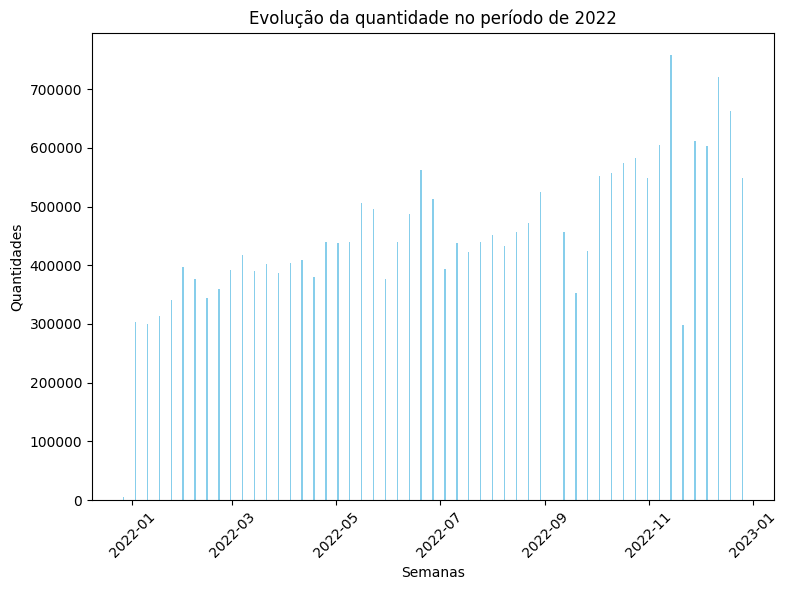

In [29]:
# Criação da figura
plt.figure(figsize=(8,6))

# Gráfico de barras
plt.bar(df_quantidade_pandas["Semanal"], df_quantidade_pandas["qtd_total"], color='skyblue')

# Título
plt.title("Evolução da quantidade no período de 2022")

# Rótulos dos eixos
plt.xlabel("Semanas")
plt.ylabel("Quantidades")

# Rotaciona o eixo X em 45%
plt.xticks(rotation=45)

 # Ajusta o layout
plt.tight_layout()

# Exibir gráfico
plt.show()

Percebe-se tendência de aumento de consumo da população, também é visível momentos de sazonalidade nas vendas em geral.

Neste momento, vamos incorporar mais dados ao dataframe para dar mais sentido à análise.

In [7]:
# Convertendo a coluna pdv do df_arquivo_1 em inteiro
df_arquivo_1 = df_arquivo_1.withColumn("pdv", col("pdv").cast("long"))

# Convertendo as colunas internal_product_id e internal_store_id do df_arquivo2_agredo em inteiro
df_arquivo2_agrupado = df_arquivo2_agrupado \
    .withColumn("internal_product_id", col("internal_product_id").cast("long")) \
    .withColumn("internal_store_id", col("internal_store_id").cast("long"))

# Convertendo a coluna produto do df_arquivo_3 em inteiro
df_arquivo_3 = df_arquivo_3.withColumn("produto", col("produto").cast("long"))

In [8]:
# Eliminando arquivos duplicados, cao exista
df_arquivo_1 = df_arquivo_1.dropDuplicates(["pdv"])
df_arquivo_3 = df_arquivo_3.dropDuplicates(["produto"])

In [9]:
# Concatenando o dataframe df_arquivo_1 e df_arquivo2_agrupado
df_concatenado = df_arquivo_1.join(df_arquivo2_agrupado , df_arquivo_1["pdv"] == df_arquivo2_agrupado["internal_store_id"], how="inner")

# Eliminando a coluna internal_store_id
df_concatenado = df_concatenado.drop("internal_store_id")

In [10]:
# Concatenando o dataframe df_concatenado e df_arquivo_3
df_analise = df_concatenado.join(df_arquivo_3, df_concatenado["internal_product_id"] == df_arquivo_3["produto"], how="inner")

# Eliminando a coluna internal_product_id
df_analise = df_analise.drop("internal_product_id")

In [11]:
# Visualizando Schema
df_analise.printSchema()

root
 |-- pdv: long (nullable = true)
 |-- premise: string (nullable = true)
 |-- categoria_pdv: string (nullable = true)
 |-- zipcode: integer (nullable = true)
 |-- Semanal: timestamp (nullable = true)
 |-- distributor_id: string (nullable = true)
 |-- qtd_total: double (nullable = true)
 |-- valor_total: double (nullable = true)
 |-- liquido_total: double (nullable = true)
 |-- lucro_bruto: double (nullable = true)
 |-- desconto: double (nullable = true)
 |-- impostos: double (nullable = true)
 |-- produto: long (nullable = true)
 |-- categoria: string (nullable = true)
 |-- descricao: string (nullable = true)
 |-- tipos: string (nullable = true)
 |-- label: string (nullable = true)
 |-- subcategoria: string (nullable = true)
 |-- marca: string (nullable = true)
 |-- fabricante: string (nullable = true)



In [35]:
# Visualizando o cabeçalho do dataframe
df_analise.show(5)

+-------------------+-----------+-------------+-------+-------------------+--------------+---------+------------------+------------------+------------------+-----------------+------------------+-------------------+-----------------+--------------------+-----------------+------------+------------+--------------------+--------------------+
|                pdv|    premise|categoria_pdv|zipcode|            Semanal|distributor_id|qtd_total|       valor_total|     liquido_total|       lucro_bruto|         desconto|          impostos|            produto|        categoria|           descricao|            tipos|       label|subcategoria|               marca|          fabricante|
+-------------------+-----------+-------------+-------+-------------------+--------------+---------+------------------+------------------+------------------+-----------------+------------------+-------------------+-----------------+--------------------+-----------------+------------+------------+--------------------+--

### Os pontos de venda mais comercializadas

In [36]:
df_analise.groupBy("categoria_pdv").agg(
    F.mean("qtd_total").alias("media_qtd_total"),
    F.stddev("valor_total").alias("desvio_valor_total")
).orderBy("media_qtd_total", ascending=False).show(10)

+-----------------+------------------+------------------+
|    categoria_pdv|   media_qtd_total|desvio_valor_total|
+-----------------+------------------+------------------+
|       Club Store|187.25005337951683|21351.495759502843|
|  Airline/Airport| 63.96640640566785|10506.189765849424|
|  Non-Traditional| 62.11764705882353| 476.6233136501713|
|  Sub Distributor| 45.83272947781328| 559.1218456870346|
| Other On Premise|29.145619727661565|1227.6655437129348|
|       Night Club|28.495660392939534|1345.7715117773766|
|Other Off Premise| 27.84183047959897|2287.0593512253436|
|  Country/Western|25.289276065793437|498.75211021189625|
|          Gay Bar| 23.64744339028521| 960.6663351887486|
|     Mexican Rest|17.833597980694226|1586.4391387854212|
+-----------------+------------------+------------------+
only showing top 10 rows



### Categorias de produtos mais comercializadas

In [37]:
df_analise.groupBy("categoria").agg(
    F.mean("qtd_total").alias("media_qtd_total"),
    F.stddev("valor_total").alias("desvio_valor_total")
).orderBy("media_qtd_total", ascending=False).show(10)

+-----------------+------------------+------------------+
|        categoria|   media_qtd_total|desvio_valor_total|
+-----------------+------------------+------------------+
|Distilled Spirits| 52.48306667814076| 2792.175491367638|
|             Wine| 19.44117054485035|235.96665030686344|
|          Package|3.8965788850603036|180.91137180373013|
|      ABA Spirits|3.0104663286080027| 143.5634883559672|
|      Non-Alcohol|2.2090391514649945| 99.52500500488624|
|          Tobacco|1.8475409836728622| 64.78887990327594|
|            Draft|1.5436620804370398|168.86748863486724|
+-----------------+------------------+------------------+



### Os tipos de primise mais comercializadas

In [38]:
df_analise.groupBy("premise").agg(
    F.mean("qtd_total").alias("media_qtd_total"),
    F.stddev("valor_total").alias("desvio_valor_total")
).orderBy("media_qtd_total", ascending=False).show(10)

+-----------+------------------+------------------+
|    premise|   media_qtd_total|desvio_valor_total|
+-----------+------------------+------------------+
| On Premise|10.276480082751483|1047.3478308584927|
|Off Premise| 8.344729316023917| 869.8612984239434|
+-----------+------------------+------------------+



### As marcas mais comercializadas

In [39]:
df_analise.groupBy("marca").agg(
    F.mean("qtd_total").alias("media_qtd_total"),
    F.stddev("valor_total").alias("desvio_valor_total")
).orderBy("media_qtd_total", ascending=False).show(10)

+--------------------+------------------+------------------+
|               marca|   media_qtd_total|desvio_valor_total|
+--------------------+------------------+------------------+
|          Sam's Club| 6443.999999985099|101535.18421002374|
|              Costco|  3433.71794846119|154798.33979875312|
|Kirkland Signatur...|2379.7037036683823| 112874.0297357418|
|Members Mark Silv...|1792.9411764705883|50601.551890492694|
|Members Mark Gold...|1582.9375001266599|15826.997548165238|
|Kirkland Signatur...|1347.4814813357812| 42218.90810584129|
|Kirkland Signatur...|1011.6249997615814|20514.595443019236|
|Members Mark 6X V...|  925.928571424314|14397.652780374667|
|Members Mark Fren...| 891.3333331982295|22044.601715902918|
|    Members Mark Gin| 788.6666666666666|10565.018069289874|
+--------------------+------------------+------------------+
only showing top 10 rows



### Os fabricantes mais comercializados

In [40]:
df_analise.groupBy("fabricante").agg(
    F.mean("qtd_total").alias("media_qtd_total"),
    F.stddev("valor_total").alias("desvio_valor_total")
).orderBy("media_qtd_total", ascending=False).show(10)

+--------------------+------------------+------------------+
|          fabricante|   media_qtd_total|desvio_valor_total|
+--------------------+------------------+------------------+
| Broken Earth Winery|137.14285714285714| 476.8213472278215|
|      The Wine Trust|             120.0|2127.4297349279173|
|American Vintners...|113.03448275862068| 1833.509215643889|
|     Sazerac Spirits| 68.06687183177104| 3133.834427469862|
|Davis Wines, Llc ...|              32.9|1339.6461131358035|
|         Civ Usa Inc|29.952831640812057| 182.2952224716312|
|    Aperture Cellars|              29.0|1005.4713065323773|
|   Boutinot Usa, Inc|27.363636363636363| 74.73723667258875|
|Lotte Beverage Am...| 25.91584699453552|134.34291534880737|
| C. Mondavi & Family|25.875299760191847|144.85375785099143|
+--------------------+------------------+------------------+
only showing top 10 rows



### Os produtos mais comercializados

In [41]:
df_analise.groupBy("produto").agg(
    F.mean("qtd_total").alias("media_qtd_total"),
    F.stddev("valor_total").alias("desvio_valor_total")
).orderBy("media_qtd_total", ascending=False).show(10)

+-------------------+------------------+------------------+
|            produto|   media_qtd_total|desvio_valor_total|
+-------------------+------------------+------------------+
|4132331673431899392| 6443.999999985099|101535.18421002373|
|7660365129551200715|  3433.71794846119| 154798.3397987531|
|1564721138677191237| 2617.633333333333| 52374.11257486753|
|3652281557572916499|2379.7037036683823| 112874.0297357418|
|3738823555271200555|1792.9411764705883|50601.551890492694|
|7825222039411973910|1582.9375001266599|15826.997548165238|
| 273773558676642674|1347.4814813357812|  42218.9081058413|
|5818312211508132638|1011.6249997615814| 20514.59544301923|
|8961542818471010617| 929.4901477832512| 10685.48046291838|
|1566422632394266453|  925.928571424314|14397.652780374665|
+-------------------+------------------+------------------+
only showing top 10 rows



### Gráfico de Pareto

In [42]:
# Agrupa por produto
df_pareto = (
    df_analise.groupBy("produto")
    .agg(F.sum("qtd_total").alias("total_vendas"))
    .orderBy(F.desc("total_vendas"))
)

In [43]:
# Convertendo o dataframe
df_pareto_pandas = df_pareto.toPandas()

In [44]:
# Calculando percentual acumulado
df_pareto_pandas["perc"] = (df_pareto_pandas["total_vendas"] / df_pareto_pandas["total_vendas"].sum()) * 100
df_pareto_pandas["perc_acumulado"] = df_pareto_pandas["perc"].cumsum()

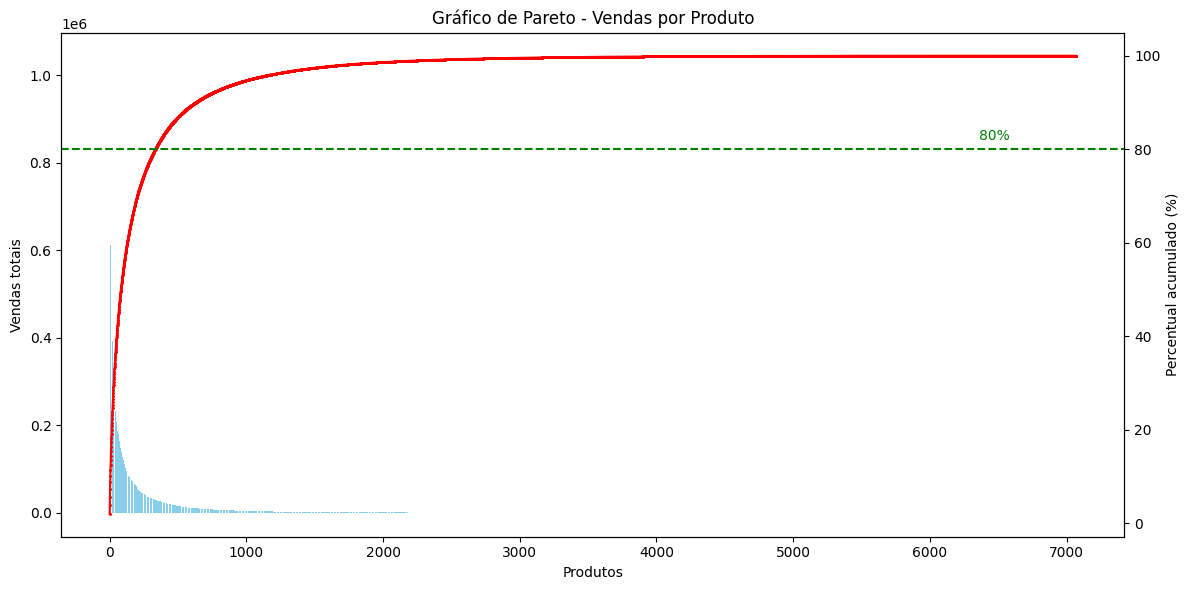

In [45]:
# Criando uma figura
fig, ax1 = plt.subplots(figsize=(12,6))

# Barras (frequência absoluta)
ax1.bar(df_pareto_pandas.index, df_pareto_pandas["total_vendas"], color="skyblue")
ax1.set_xlabel("Produtos")
ax1.set_ylabel("Vendas totais")

# Linha (frequência acumulada)
ax2 = ax1.twinx()
ax2.plot(df_pareto_pandas.index, df_pareto_pandas["perc_acumulado"], color="red", marker="D", ms=1)
ax2.set_ylabel("Percentual acumulado (%)")

# Linha de referência 80%
ax2.axhline(80, color="green", linestyle="--")
ax2.text(len(df_pareto_pandas)*0.9, 82, "80%", color="green")

# Título e imprime em tela
plt.title("Gráfico de Pareto - Vendas por Produto")
plt.tight_layout()
plt.show()

### Correlação entre as variáveis

In [46]:
# Criando o dicionário de colunas
cols = ["zipcode", "qtd_total", "valor_total", "liquido_total", "lucro_bruto", "desconto", "impostos"]

# criando a matriz vazia
cor_matrix = pd.DataFrame(index=cols, columns=cols, dtype=float)

# preenche matriz com correlações
for i in range(len(cols)):
    for j in range(i, len(cols)):
        c1, c2 = cols[i], cols[j]
        if c1 == c2:
            cor_matrix.loc[c1, c2] = 1.0
        else:
            valor = df_analise.select(F.corr(c1, c2)).collect()[0][0]
            cor_matrix.loc[c1, c2] = valor
            cor_matrix.loc[c2, c1] = valor

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/socket.py", line 720, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
# Criando a figura
plt.figure(figsize=(8,6))

# Gráfico heatmap
sns.heatmap(cor_matrix, annot=True, cmap="coolwarm", fmt=".2f")

# Inserindo o título
plt.title("Matriz de Correlação")

# Imprimindo o gráfico em tela
plt.show()

Comentários:

1. Quantidade (qtd_total) e Valores (valor_total, liquido_total)

   - Correlação muito forte e positiva (≈ 0,82).

   - Isso mostra que, à medida que a quantidade vendida aumenta, o faturamento bruto e líquido também crescem de forma consistente.

   - Já era esperado, pois a quantidade é diretamente multiplicada pelo preço.


2. Valor Total vs. Valor Líquido

   - Correlação praticamente perfeita (≈ 1,00).

   - Indica que o valor líquido segue quase exatamente o mesmo comportamento do valor bruto, provavelmente com diferenças apenas pelos descontos e impostos.

3. Quantidade e Desconto

   - Correlação positiva moderada (≈ 0,53).

   - Sugere que quanto maior a quantidade vendida, maior tende a ser o desconto aplicado — possivelmente por política comercial (ex.: desconto progressivo em compras grandes).

4. Valor (bruto/líquido) e Desconto

    - Correlação moderada positiva (≈ 0,57).

    - Reflete que transações de maior valor envolvem descontos mais altos em termos absolutos.

5. Lucro Bruto

    - Correlação baixa com quantidade e valores (≈ 0,26 a 0,28).

    - Isso pode indicar que o lucro não cresce proporcionalmente às vendas — possivelmente devido à variação de margens entre produtos.

    - Correlação negativa com descontos (-0,20), ou seja: descontos elevados tendem a reduzir o lucro bruto.

6. Impostos

   - Correlação baixa com quase todas as variáveis.

   - Única correlação um pouco mais notável é negativa com zipcode (-0,24), o que pode estar relacionado a diferenças de regimes tributários ou variações regionais, mas precisaria ser investigado.

    - No geral, os impostos parecem variar de forma independente.

7. Zipcode

   - Baixíssima correlação com quase tudo.

   - Isso sugere que o CEP (localização do PDV/cliente) não tem influência direta nos valores financeiros ou quantidades neste conjunto.

## Armazenamento, encerrando a sessão Spark e obtenção de requiriments.txt

In [12]:
# Salvar o dataframe em uma única partição, com cabeçalhos das colunas e no formato parquet
df_analise.coalesce(1) \
  .write \
  .option("compression", "snappy") \
  .mode("overwrite") \
  .parquet("dados_analise.parquet")

In [13]:
# Encerra a sessão spark
spark.stop()

In [15]:
# Criando o nome do arquivo
arquivo = 'requirements.txt'

In [16]:
# Criando o arquivo e salvando
with open(arquivo, 'w') as f:
    subprocess.check_call(['pip', 'freeze'], stdout=f)

# Imprimindo a mensagem
print(f"Arquivo '{arquivo}' criado com sucesso!")

Arquivo 'requirements.txt' criado com sucesso!
